LSTM

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import KNNImputer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# === Step 1: 讀取資料 ===
data = pd.read_csv('/content/all_plot_cleandata.csv', encoding='utf-8')

# === Step 2: 新增轉變標籤 ===
data['Transition'] = data.groupby('USER_ID_HASH')['Exhausted_state'].transform(
    lambda x: (x.shift() == 0) & (x == 1)
).astype(int)

# === Step 3: 計算首次轉變時間差 ===
def calculate_time_diff(df):
    start_time = df['time'].iloc[0]
    if df['Transition'].sum() > 0:  # 如果有轉變
        transition_time = df.loc[df['Transition'] == 1, 'time'].iloc[0]
        df['time_diff_to_first_exhausted'] = transition_time - start_time
    else:
        df['time_diff_to_first_exhausted'] = None
    return df

data = data.groupby('USER_ID_HASH', group_keys=False, as_index=False).apply(calculate_time_diff)

# === Step 4: 計算移動特徵 ===
def add_moving_features(df):
    df['distance_moving_avg'] = df.groupby('USER_ID_HASH')['distance'].transform(
        lambda x: x.rolling(window=5, min_periods=1).mean()
    )
    return df

data = add_moving_features(data)

# === Step 5: 過濾資料 ===
def filter_first_transition(df):
    if df['Transition'].sum() == 0:
        return df
    first_transition_index = df[df['Transition'] == 1].index[0]
    return df[df.index <= first_transition_index]

filtered_data = data.groupby('USER_ID_HASH', group_keys=False).apply(filter_first_transition).reset_index(drop=True)

# 填補缺失值
imputer = KNNImputer(n_neighbors=5)
filtered_data['time_diff_to_first_exhausted'] = imputer.fit_transform(filtered_data[['time_diff_to_first_exhausted']])

# 特徵選擇
y = filtered_data['time_diff_to_first_exhausted']
X = filtered_data[['distance', 'distance_moving_avg']]  # 這裡選了主要特徵，你可以根據需求調整

# === Step 6: 標準化數據 & 時間步長設置 ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 時序化數據
time_steps = 10  # 設定時間步長
def create_time_series(X, y, time_steps):
    X_time_series, y_time_series = [], []
    for i in range(len(X) - time_steps):
        X_time_series.append(X[i:i + time_steps])
        y_time_series.append(y[i + time_steps])
    return np.array(X_time_series), np.array(y_time_series)

X_time_series, y_time_series = create_time_series(X_scaled, y.values, time_steps)

# 切分資料集
X_train, X_test, y_train, y_test = train_test_split(X_time_series, y_time_series, test_size=0.2, random_state=42)


# 回調函數
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# 優化後的 LSTM 模型
model = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),  # 增加 Dropout
    BatchNormalization(),  # 加入批次正規化
    LSTM(64, activation='tanh', return_sequences=False),
    Dropout(0.3),
    Dense(32),
    LeakyReLU(alpha=0.1),  # 使用 LeakyReLU 代替 ReLU
    Dense(16),
    LeakyReLU(alpha=0.1),
    Dense(1)  # 輸出層
])

# 編譯模型
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

# 訓練模型
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=128,  # 增大批量大小，可能加速收斂
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# 評估模型
y_pred = model.predict(X_test)
mae = np.mean(np.abs(y_test - y_pred.flatten()))
r2 = r2_score(y_test, y_pred)

print("=== 模型評估結果 ===")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, y_pred):.4f}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
print(f"R² Score: {r2:.4f}")

<ipython-input-2-18124a0ec175>:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = data.groupby('USER_ID_HASH', group_keys=False, as_index=False).apply(calculate_time_diff)
<ipython-input-2-18124a0ec175>:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('USER_ID_HASH', group_keys=False, as_index=False).apply(calculate_time_diff)
<ipython-input-2-18124a0ec175>:49: DeprecationWarning: DataFrameGroupBy.apply operated on the group

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - loss: 737.7543 - mae: 26.8435 - val_loss: 744.5156 - val_mae: 26.9646 - learning_rate: 1.0000e-04
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 725.2964 - mae: 26.5761 - val_loss: 741.3126 - val_mae: 26.9045 - learning_rate: 1.0000e-04
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 715.8321 - mae: 26.4197 - val_loss: 737.4341 - val_mae: 26.8313 - learning_rate: 1.0000e-04
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 692.1136 - mae: 25.9213 - val_loss: 732.4086 - val_mae: 26.7361 - learning_rate: 1.0000e-04
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 684.0806 - mae: 25.7639 - val_loss: 725.7617 - val_mae: 26.6094 - learning_rate: 1.0000e-04
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 643.8372 - mae: 25.0060 - val_loss: 716.7482 - val_mae: 26.4357 - learning_rate: 1.0000e-04
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 626.0988 - mae: 24.6484 - 

RNN


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# === Step 1: 讀取資料 ===
data = pd.read_csv('/content/all_plot_cleandata.csv', encoding='utf-8')

# === Step 2: 新增轉變標籤 ===
data['Transition'] = data.groupby('USER_ID_HASH')['Exhausted_state'].transform(
    lambda x: (x.shift() == 0) & (x == 1)
).astype(int)

# === Step 3: 計算首次轉變時間差 ===
def calculate_time_diff(df):
    start_time = df['time'].iloc[0]
    if df['Transition'].sum() > 0:  # 如果有轉變
        transition_time = df.loc[df['Transition'] == 1, 'time'].iloc[0]
        df['time_diff_to_first_exhausted'] = transition_time - start_time
    else:
        df['time_diff_to_first_exhausted'] = None
    return df

data = data.groupby('USER_ID_HASH', group_keys=False, as_index=False).apply(calculate_time_diff)

# === Step 4: 計算移動特徵 ===
def add_moving_features(df):
    df['distance_moving_avg'] = df.groupby('USER_ID_HASH')['distance'].transform(
        lambda x: x.rolling(window=5, min_periods=1).mean()
    )
    df['cumulative_distance'] = df.groupby('USER_ID_HASH')['distance'].cumsum()
    df['cumulative_time'] = df.groupby('USER_ID_HASH')['time'].transform(lambda x: x - x.min())
    return df

data = add_moving_features(data)

# === Step 5: 過濾資料 ===
def filter_first_transition(df):
    if df['Transition'].sum() == 0:
        return df
    first_transition_index = df[df['Transition'] == 1].index[0]
    return df[df.index <= first_transition_index]

filtered_data = data.groupby('USER_ID_HASH', group_keys=False).apply(filter_first_transition).reset_index(drop=True)

# 填補缺失值
imputer = KNNImputer(n_neighbors=5)
filtered_data['time_diff_to_first_exhausted'] = imputer.fit_transform(filtered_data[['time_diff_to_first_exhausted']])

# 特徵選擇
y = filtered_data['time_diff_to_first_exhausted']
X = filtered_data[['distance', 'distance_moving_avg']]

# === Step 6: 標準化數據 & 時間步長設置 ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 時序化數據
time_steps = 10  # 設定時間步長
def create_time_series(X, y, time_steps):
    X_time_series, y_time_series = [], []
    for i in range(len(X) - time_steps):
        X_time_series.append(X[i:i + time_steps])
        y_time_series.append(y[i + time_steps])
    return np.array(X_time_series), np.array(y_time_series)

X_time_series, y_time_series = create_time_series(X_scaled, y.values, time_steps)

# 切分資料集
X_train, X_test, y_train, y_test = train_test_split(X_time_series, y_time_series, test_size=0.2, random_state=42)

# === Step 7: 建立 RNN 模型 ===
model = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),  # 增加 Dropout
    BatchNormalization(),  # 加入批次正規化
    LSTM(64, activation='tanh', return_sequences=False),
    Dropout(0.3),
    Dense(32),
    LeakyReLU(alpha=0.1),  # 使用 LeakyReLU 代替 ReLU
    Dense(16),
    LeakyReLU(alpha=0.1),
    Dense(1)  # 輸出層
])

# 編譯模型
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

# 回調函數
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# === Step 8: 訓練模型 ===
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=128,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# === Step 9: 評估模型 ===
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred.flatten())
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("=== 模型評估結果 ===")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

<ipython-input-3-90bd1f0804a3>:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = data.groupby('USER_ID_HASH', group_keys=False, as_index=False).apply(calculate_time_diff)
<ipython-input-3-90bd1f0804a3>:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('USER_ID_HASH', group_keys=False, as_index=False).apply(calculate_time_diff)
<ipython-input-3-90bd1f0804a3>:48: DeprecationWarning: DataFrameGroupBy.apply operated on the group

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - loss: 731.2254 - mae: 26.7430 - val_loss: 743.7923 - val_mae: 26.9520 - learning_rate: 1.0000e-04
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 719.5164 - mae: 26.4520 - val_loss: 739.2968 - val_mae: 26.8694 - learning_rate: 1.0000e-04
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 698.5239 - mae: 26.0827 - val_loss: 733.3384 - val_mae: 26.7590 - learning_rate: 1.0000e-04
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 675.8227 - mae: 25.6611 - val_loss: 725.5425 - val_mae: 26.6127 - learning_rate: 1.0000e-04
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 649.1505 - mae: 25.1233 - val_loss: 714.8561 - val_mae: 26.4105 - learning_rate: 1.0000e-04
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 614.7086 - mae: 24.4301 - val_loss: 700.1863 - val_mae: 26.1298 - learning_rate: 1.0000e-04
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 584.2412 - mae: 23.7595 -

In [ ]:
filtered_data.columns.tolist()

['USER_ID_HASH',
 'age',
 'gender',
 'right_eye_condition',
 'right_eye_degree',
 'right_eye_shine',
 'right_eye_shine_degree',
 'left_eye_condition',
 'left_eye_degree',
 'left_eye_shine',
 'left_eye_shine_degree',
 'eye_situation_value1',
 'eye_situation_value2',
 'eye_situation_value3',
 'eye_situation_value4',
 'eye_situation_value5',
 'use_situation1',
 'use_situation3',
 'habit1',
 'distance',
 'brightness_x',
 'blink_x',
 'state',
 'Exhausted_state',
 'time',
 'distance_ratio',
 'brightness_y',
 'blink_y',
 'blink_num',
 'question_5',
 'question_6',
 'question_7',
 'question_8',
 'question_9',
 'question_10',
 'question_11',
 'use_situation2_3小時以內',
 'use_situation2_3至6小時',
 'use_situation2_6-9小時',
 'use_situation2_9-12小時',
 'use_situation2_12小時以上',
 'use_situation_value4_電腦自動調整',
 'use_situation_value4_不常調整',
 'use_situation_value4_每次使用都會調整',
 'use_situation_value5_僅室內共用燈光',
 'use_situation_value5_僅室內專用燈光',
 'use_situation_value5_室內共用與專用燈光皆有',
 'use_situation_value5_戶外',
 'use_

In [ ]:
import joblib
# 儲存模型
joblib.dump(model, 'modelrnn.joblib')  # 將模型保存到文件中
joblib.dump(scaler, 'scalerrnn.joblib')        # 保存標準化對象

print("模型已成功保存！")

模型已成功保存！


##預測

In [ ]:
import joblib

# 載入保存的模型和標準化器
model = joblib.load('modelrnn.joblib')
scaler = joblib.load('scalerrnn.joblib')

In [ ]:
import pandas as pd
import numpy as np

new_data = pd.read_csv('/content/Joy_final_data.csv', encoding='utf-8')

# 處理新資料集的特徵選擇（根據訓練時選擇的特徵進行處理）
new_data_selected = new_data[['age',
 'gender',
 'right_eye_condition',
 'right_eye_degree',
 'right_eye_shine',
 'right_eye_shine_degree',
 'left_eye_condition',
 'left_eye_degree',
 'left_eye_shine',
 'left_eye_shine_degree',
 'eye_situation_value1',
 'eye_situation_value3',
 'eye_situation_value4',
 'eye_situation_value5',
 'use_situation1',
 'use_situation3',
 'habit1',
 'distance',
 'brightness_x',
 'blink_x',
 'state',
 'Exhausted_state',
 'time',
 'distance_ratio',
 'brightness_y',
 'blink_y',
 'blink_num',
 'question_5',
 'question_6',
 'question_7',
 'question_8',
 'question_9',
 'question_10',
 'question_11',
 'use_situation2_3小時以內',
 'use_situation2_3至6小時',
 'use_situation2_6-9小時',
 'use_situation2_9-12小時',
 'use_situation2_12小時以上',
 'use_situation_value4_電腦自動調整',
 'use_situation_value4_不常調整',
 'use_situation_value4_每次使用都會調整',
 'use_situation_value5_僅室內共用燈光',
 'use_situation_value5_僅室內專用燈光',
 'use_situation_value5_室內共用與專用燈光皆有',
 'use_situation_value5_戶外',
 'use_situation_value5_光線明顯不足之環境',
 'use_situation_value5_其他',
 'habit2_無',
 'habit2_半年一次',
 'habit2_一年一次',
 'habit2_更頻繁',
 'habit3_低於4小時',
 'habit3_4至6小時',
 'habit3_6至8小時',
 'habit3_高於8小時',
 'habit4_0或1次',
 'habit4_2或3次',
 'habit4_4或5次',
 'habit4_6次以上',
 'habit5_無休息',
 'habit6_10分鐘內',
 'habit7_閉目養神',
 'habit7_閉目養神, 眼部運動, 其他',
 'question_1_電腦',
 'question_1_平板',
 'question_1_其他',
 'question_2_工作/實習用途',
 'question_2_聆聽線上課程',
 'question_2_完成學校作業',
 'question_2_其他',
 'question_3_僅室內共用燈光',
 'question_3_其他',
 'question_4_無',
 'question_4_配戴眼鏡',
 'question_4_配戴隱形眼鏡',
 'brightness_moving_avg',
 'distance_variance']]  # 根據你的特徵選擇

print(len(new_data_selected.columns))

# 對新資料進行標準化
new_data_scaled = scaler.transform(new_data_selected)

# 時序化資料
def create_time_series(X, time_steps):
    X_time_series = []
    for i in range(len(X) - time_steps):
        X_time_series.append(X[i:i + time_steps])
    return np.array(X_time_series)

time_steps = 10  # 時間步長設定為與訓練時相同
new_data_time_series = create_time_series(new_data_scaled, time_steps)


78


In [ ]:
# 使用已載入的模型進行預測
predictions = model.predict(new_data_time_series)

# 預測結果
print(predictions)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
[[3.35535  ]
 [3.3680477]
 [3.3701365]
 [3.364417 ]
 [3.3616483]
 [3.3565297]
 [3.3515337]
 [3.3531446]
 [3.3500657]
 [3.3464947]
 [3.3471117]
 [3.3393412]
 [3.3344166]
 [3.3405294]
 [3.3428555]
 [3.3476076]
 [3.3620498]
 [3.3586001]
 [3.3529618]
 [3.346035 ]
 [3.3436313]
 [3.341132 ]
 [3.3390493]
 [3.3356838]
 [3.3310742]
 [3.3409145]
 [3.3460069]
 [3.3410215]
 [3.33735  ]
 [3.3373573]
 [3.3335857]
 [3.3320065]
 [3.3293822]
 [3.3283105]
 [3.3308744]
 [3.3292532]
 [3.324361 ]
 [3.3251314]
 [3.3247054]
 [3.327608 ]
 [3.3317504]
 [3.332581 ]
 [3.3361502]
 [3.3418922]
 [3.3444777]
 [3.3432543]
 [3.3444138]
 [3.355331 ]
 [3.3528364]
 [3.3533704]
 [3.3631754]
 [3.3796318]
 [3.3882756]
 [3.39531  ]
 [3.3975143]
 [3.402921 ]
 [3.4122581]
 [3.4121957]
 [3.4170299]
 [3.4073596]
 [3.4327335]
 [3.433877 ]
 [3.4270601]
 [3.4214573]
 [3.4138985]
 [3.40584  ]
 [3.39893  ]
 [3.3904958]
 [3.3858602]
 [3.3809338]
 [3.381147 ]
 [3.3830566]
 [3.3840938]
 [3.38197  

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 假設 'true_values' 是新資料的真實標籤
true_values = new_data['time_diff_to_first_exhausted'].iloc[time_steps:].values  # 根據時間步長調整

# 計算評估指標
mae = mean_absolute_error(true_values, predictions)
mse = mean_squared_error(true_values, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(true_values, predictions)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error (MAE): 11.3557
Mean Squared Error (MSE): 311.5042
Root Mean Squared Error (RMSE): 17.6495
R² Score: -0.1498


In [ ]:
# 將預測結果存到 DataFrame
predictions_df = pd.DataFrame(predictions, columns=['Predicted_time_diff'])

# 保存預測結果
predictions_df.to_csv('predictions.csv', index=False)

##XGBoost

In [ ]:
# === 重建回歸模型代碼 ===
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import joblib

# 訓練模型函數
def fit_xgb_model(X_train, y_train):
    model = XGBRegressor(
        objective='reg:squarederror',
        max_depth=6,
        learning_rate=0.05,
        n_estimators=300,
        random_state=42
    )
    model.fit(X_train, y_train)
    return model

# 讀取資料
data = pd.read_csv('/content/all_plot_cleandata.csv', encoding='utf-8')

# 特徵工程與預處理
def calculate_time_diff(df):
    start_time = df['time'].iloc[0]
    if df['Transition'].sum() > 0:
        transition_time = df.loc[df['Transition'] == 1, 'time'].iloc[0]
        df['time_diff_to_first_exhausted'] = transition_time - start_time
    else:
        df['time_diff_to_first_exhausted'] = 0
    return df

data = data.groupby('USER_ID_HASH', group_keys=False, as_index=False).apply(calculate_time_diff)

data['distance_moving_avg'] = data.groupby('USER_ID_HASH')['distance'].transform(
    lambda x: x.rolling(window=5, min_periods=1).mean()
)

data['distance_variance'] = data.groupby('USER_ID_HASH')['distance'].transform(
    lambda x: x.rolling(window=5, min_periods=1).var()
)

# 填補缺失值
imputer = SimpleImputer(strategy='mean')
data['time_diff_to_first_exhausted'] = imputer.fit_transform(data[['time_diff_to_first_exhausted']])

# 特徵選擇
corr_matrix = data.corr()
mean_corr = corr_matrix.mean().sort_values(ascending=False)
top_features = mean_corr.head(7).index

# 訓練模型與調參
features = data[top_features]
target = data['time_diff_to_first_exhausted']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

model = fit_xgb_model(X_train, y_train)
joblib.dump(model, 'xgboost_regression_model.pkl')

<ipython-input-2-dbf6cb6cf8fb>:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('USER_ID_HASH', group_keys=False, as_index=False).apply(calculate_time_diff)


['xgboost_regression_model.pkl']

In [ ]:
# === 測試模型代碼 ===
test_data = pd.read_csv('/content/RYAN_final_data.csv', encoding='utf-8')

test_data['Transition'] = test_data.groupby('USER_ID_HASH')['Exhausted_state'].transform(
    lambda x: (x.shift() == 0) & (x == 1)
).astype(int)

test_data = test_data.groupby('USER_ID_HASH', group_keys=False, as_index=False).apply(calculate_time_diff)

test_data['distance_moving_avg'] = test_data.groupby('USER_ID_HASH')['distance'].transform(
    lambda x: x.rolling(window=5, min_periods=1).mean()
)

test_data['time_diff_to_first_exhausted'] = imputer.transform(test_data[['time_diff_to_first_exhausted']])

test_features = test_data[top_features]
new_predictions = model.predict(test_features)

# 模型評估與視覺化
new_report = classification_report(test_data['Transition'], new_predictions, output_dict=True)
new_result_df = pd.DataFrame(new_report).transpose()
print(new_result_df)

cm = confusion_matrix(test_data['Transition'], new_predictions)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Transition', 'Transition'], yticklabels=['No Transition', 'Transition'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('New Test Set Confusion Matrix')
plt.show()

# 顯示ROC與PR曲線
probs = model.predict_proba(test_features)[:, 1]
fpr, tpr, _ = roc_curve(test_data['Transition'], probs)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(test_data['Transition'], probs):.2f})")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

precision, recall, _ = precision_recall_curve(test_data['Transition'], probs)
plt.figure(figsize=(8,6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

<ipython-input-3-5d3725cc75e0>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_data = test_data.groupby('USER_ID_HASH', group_keys=False, as_index=False).apply(calculate_time_diff)


NameError: name 'classification_report' is not defined

In [ ]:
# 匯入必要函式庫
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, mean_absolute_percentage_error
from sklearn.impute import KNNImputer
from xgboost import XGBRegressor

# === 步驟 1: 讀取資料 ===
file_path = '/content/all_plot_cleandata.csv'
data = pd.read_csv(file_path)

# === 步驟 2: 新增轉變標籤 ===
data['Transition'] = data.groupby('USER_ID_HASH')['Exhausted_state'].transform(
    lambda x: (x.shift() == 0) & (x == 1)
).astype(int)

# === 步驟 3: 計算首次轉變時間差 ===
def calculate_time_diff(df):
    start_time = df['time'].iloc[0]
    if df['Transition'].sum() > 0:  # 如果有轉變
        transition_time = df.loc[df['Transition'] == 1, 'time'].iloc[0]
        df['time_diff_to_first_exhausted'] = transition_time - start_time
    else:
        df['time_diff_to_first_exhausted'] = 0  # 填補為 0
    return df

data = data.groupby('USER_ID_HASH', group_keys=False, as_index=False).apply(calculate_time_diff)

# === 步驟 4: 計算移動特徵 ===
def add_moving_features(df):
    df['distance_moving_avg'] = df.groupby('USER_ID_HASH')['distance'].transform(
        lambda x: x.rolling(window=5, min_periods=1).mean()
    )
    df['cumulative_distance'] = df.groupby('USER_ID_HASH')['distance'].cumsum()
    df['cumulative_time'] = df.groupby('USER_ID_HASH')['time'].transform(lambda x: x - x.min())
    return df

data = add_moving_features(data)

# === 步驟 5: 過濾資料 ===
def filter_first_transition(df):
    if df['Transition'].sum() == 0:
        return df
    first_transition_index = df[df['Transition'] == 1].index[0]
    return df[df.index <= first_transition_index]

filtered_data = data.groupby('USER_ID_HASH', group_keys=False).apply(filter_first_transition).reset_index(drop=True)

# 填補缺失值
imputer = KNNImputer(n_neighbors=5)
filtered_data.fillna(0, inplace=True)  # 避免 NaN 引發錯誤

# === 步驟 6: 特徵選擇 ===
correlation_matrix = filtered_data.corr()
target_variable = 'time_diff_to_first_exhausted'

# 對數變換目標值
filtered_data['log_time_diff'] = np.log1p(filtered_data[target_variable])

selected_features = correlation_matrix[target_variable][correlation_matrix[target_variable].abs() > 0.2].index.tolist()
selected_features.remove(target_variable)

# 儲存選擇的特徵
selected_features_file = '/content/selected_features.pkl'
joblib.dump(selected_features, selected_features_file)
print(f"\n特徵選擇結果已儲存至: {selected_features_file}")

# 確保完整的特徵名稱一致性
X = filtered_data[selected_features]
y = filtered_data['log_time_diff']

# === 步驟 7: 資料切分 ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === 步驟 8: 建立與訓練 XGBoost 模型 ===
xgb_model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, subsample=0.8, random_state=42)
xgb_model.fit(X_train, y_train)

# 儲存模型至檔案
model_file = '/content/xgb_model.pkl'
try:
    joblib.dump(xgb_model, model_file)
    print(f"\n模型已成功儲存至: {model_file}")
except Exception as e:
    print(f"\n模型儲存失敗: {e}")

# === 步驟 9: 模型評估 ===
y_pred = xgb_model.predict(X_test)

# 還原對數變換
y_test_original = np.expm1(y_test)
y_pred_original = np.expm1(y_pred)

mae = mean_absolute_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)
mse = mean_squared_error(y_test_original, y_pred_original)
mape = mean_absolute_percentage_error(y_test_original, y_pred_original)

accuracy = np.mean(np.round(y_pred_original) == np.round(y_test_original))

print(f"模型: XGBoost Regressor")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R² 分數: {r2:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"準確率 (Accuracy): {accuracy:.4f}")


<ipython-input-1-b9a0801792ef>:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('USER_ID_HASH', group_keys=False, as_index=False).apply(calculate_time_diff)
<ipython-input-1-b9a0801792ef>:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_data = data.groupby('USER_ID_HASH', group_keys=False).apply(filter_first_transition).reset_index(drop=True)



特徵選擇結果已儲存至: /content/selected_features.pkl

模型已成功儲存至: /content/xgb_model.pkl
模型: XGBoost Regressor
MAE: 0.0744
MSE: 0.5164
R² 分數: 0.9952
MAPE: 23609217710042.2539
準確率 (Accuracy): 0.9862


##最終程式碼

In [ ]:
# 匯入必要函式庫
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, mean_absolute_percentage_error
from sklearn.impute import KNNImputer
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler

# === 步驟 1: 讀取資料 ===
file_path = '/content/all_plot_cleandata.csv'
data = pd.read_csv(file_path)

# === 步驟 2: 新增轉變標籤 ===
data['Transition'] = data.groupby('USER_ID_HASH')['Exhausted_state'].transform(
    lambda x: (x.shift() == 0) & (x == 1)
).astype(int)

# === 步驟 3: 計算首次轉變時間差 ===
def calculate_time_diff(df):
    start_time = df['time'].iloc[0]
    if df['Transition'].sum() > 0:  # 如果有轉變
        transition_time = df.loc[df['Transition'] == 1, 'time'].iloc[0]
        df['time_diff_to_first_exhausted'] = transition_time - start_time
    else:
        df['time_diff_to_first_exhausted'] = 0  # 填補為 0
    return df

data = data.groupby('USER_ID_HASH', group_keys=False, as_index=False).apply(calculate_time_diff)

# === 步驟 4: 計算移動特徵與累積效應特徵 ===
def add_moving_features(df):
    df['distance_moving_avg'] = df.groupby('USER_ID_HASH')['distance'].transform(
        lambda x: x.rolling(window=3, min_periods=1).mean()
    )
    df['cumulative_distance'] = df.groupby('USER_ID_HASH')['distance'].cumsum()
    df['cumulative_time'] = df.groupby('USER_ID_HASH')['time'].transform(lambda x: x - x.min())
    return df

data = add_moving_features(data)

# === 步驟 5: 過濾資料 ===
def filter_first_transition(df):
    if df['Transition'].sum() == 0:
        return df
    first_transition_index = df[df['Transition'] == 1].index[0]
    return df[df.index <= first_transition_index]

filtered_data = data.groupby('USER_ID_HASH', group_keys=False).apply(filter_first_transition).reset_index(drop=True)

# 填補缺失值
imputer = KNNImputer(n_neighbors=5)
filtered_data.fillna(0, inplace=True)  # 避免 NaN 引發錯誤

# === 步驟 6: 特徵選擇 ===
correlation_matrix = filtered_data.corr()
target_variable = 'time_diff_to_first_exhausted'

# 對數變換目標值
filtered_data['log_time_diff'] = np.log1p(filtered_data[target_variable] + 1e-5)

selected_features = correlation_matrix[target_variable][correlation_matrix[target_variable].abs() > 0.2].index.tolist()
selected_features.remove(target_variable)

print(selected_features)

# 儲存選擇的特徵
selected_features_file = '/content/selected_features.pkl'
joblib.dump(selected_features, selected_features_file)
print(f"\n特徵選擇結果已儲存至: {selected_features_file}")

# 確保完整的特徵名稱一致性
X = filtered_data[selected_features]
y = filtered_data['log_time_diff']

# === 步驟 7: 資料切分 ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === 步驟 8: 建立與訓練 XGBoost 模型 ===
xgb_model = XGBRegressor(n_estimators=300, max_depth=5, learning_rate=0.1, subsample=0.8, random_state=42)
xgb_model.fit(X_train, y_train)

# 儲存模型至檔案
model_file = '/content/xgb_model.pkl'
try:
    joblib.dump(xgb_model, model_file)
    print(f"\nXGBoost 模型已成功儲存至: {model_file}")
except Exception as e:
    print(f"\nXGBoost 模型儲存失敗: {e}")

# === 步驟 9: 建立與訓練 RNN 模型 ===
# 標準化數據
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 儲存標準化器
scaler_file = '/content/scaler.pkl'
joblib.dump(scaler, scaler_file)
print(f"\n標準化器已成功儲存至: {scaler_file}")

# RNN 需要 3D 輸入
X_train_rnn = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_rnn = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

y_train_rnn = y_train.values
y_test_rnn = y_test.values

# 建立 RNN 模型
rnn_model = Sequential([
    LSTM(100, activation='relu', return_sequences=True, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

rnn_model.compile(optimizer='adam', loss='mean_squared_error')
rnn_model.fit(X_train_rnn, y_train_rnn, epochs=30, batch_size=32, verbose=1)

# 儲存 RNN 模型至檔案
rnn_model_file = '/content/rnn_model.h5'
try:
    rnn_model.save(rnn_model_file)
    print(f"\nRNN 模型已成功儲存至: {rnn_model_file}")
except Exception as e:
    print(f"\nRNN 模型儲存失敗: {e}")

# === 步驟 10: 評估 XGBoost 和 RNN 模型 ===
# XGBoost 評估
y_pred_xgb = xgb_model.predict(X_test)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

# RNN 評估
y_pred_rnn = rnn_model.predict(X_test_rnn).flatten()
mae_rnn = mean_absolute_error(y_test, y_pred_rnn)

# 還原對數變換
y_test_original = np.expm1(y_test)
y_pred_xgb_original = np.expm1(y_pred_xgb)
y_pred_rnn_original = np.expm1(y_pred_rnn)

# 基於模型性能調整權重
weight_xgb = 1 / mae_xgb
weight_rnn = 1 / mae_rnn
total_weight = weight_xgb + weight_rnn
weight_xgb /= total_weight
weight_rnn /= total_weight

# 加權融合
y_pred_ensemble = weight_xgb * y_pred_xgb_original + weight_rnn * y_pred_rnn_original

# 評估指標
mae = mean_absolute_error(y_test_original, y_pred_ensemble)
r2 = r2_score(y_test_original, y_pred_ensemble)
mse = mean_squared_error(y_test_original, y_pred_ensemble)
mape = mean_absolute_percentage_error(y_test_original, y_pred_ensemble)
accuracy = np.mean(np.round(y_pred_ensemble) == np.round(y_test_original))

print(f"模型融合 (XGBoost + RNN) 評估:\nMAE: {mae:.4f}\nMSE: {mse:.4f}\nR² 分數: {r2:.4f}\nMAPE: {mape:.4f}\n準確率 (Accuracy): {accuracy:.4f}")
print(f"權重: XGBoost = {weight_xgb:.2f}, RNN = {weight_rnn:.2f}")

<ipython-input-1-8171076538e9>:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('USER_ID_HASH', group_keys=False, as_index=False).apply(calculate_time_diff)
<ipython-input-1-8171076538e9>:52: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_data = data.groupby('USER_ID_HASH', group_keys=False).apply(filter_first_transition).reset_index(drop=True)


['right_eye_condition', 'left_eye_degree', 'left_eye_shine_degree', 'eye_situation_value1', 'eye_situation_value2', 'eye_situation_value3', 'eye_situation_value5', 'habit1', 'distance', 'time', 'distance_ratio', 'blink_y', 'question_5', 'question_7', 'question_11', 'use_situation2_3至6小時', 'use_situation_value4_電腦自動調整', 'use_situation_value4_每次使用都會調整', 'habit4_0或1次', 'habit4_2或3次', 'habit7_眼部運動', 'question_2_完成學校作業', 'distance_moving_avg']

特徵選擇結果已儲存至: /content/selected_features.pkl

XGBoost 模型已成功儲存至: /content/xgb_model.pkl

標準化器已成功儲存至: /content/scaler.pkl


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 1.4754
Epoch 2/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0134
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5048
Epoch 4/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3308
Epoch 5/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2612
Epoch 6/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2116
Epoch 7/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2003
Epoch 8/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1766
Epoch 9/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1661
Epoch 10/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1197
Epoch 11/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1666
Epoch 12/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1251
Epoch 13/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1052
Epoch 14/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1358
Epoch 15/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1272
Epoch 16/30
55/55 


RNN 模型已成功儲存至: /content/rnn_model.h5
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
模型融合 (XGBoost + RNN) 評估:
MAE: 0.1098
MSE: 0.5180
R² 分數: 0.9952
MAPE: 268.9680
準確率 (Accuracy): 0.9493
權重: XGBoost = 0.92, RNN = 0.08


<ipython-input-2-438bddd35290>:20: UserWarning: Glyph 38651 (\N{CJK UNIFIED IDEOGRAPH-96FB}) missing from current font.
  plt.tight_layout()
<ipython-input-2-438bddd35290>:20: UserWarning: Glyph 33126 (\N{CJK UNIFIED IDEOGRAPH-8166}) missing from current font.
  plt.tight_layout()
<ipython-input-2-438bddd35290>:20: UserWarning: Glyph 33258 (\N{CJK UNIFIED IDEOGRAPH-81EA}) missing from current font.
  plt.tight_layout()
<ipython-input-2-438bddd35290>:20: UserWarning: Glyph 21205 (\N{CJK UNIFIED IDEOGRAPH-52D5}) missing from current font.
  plt.tight_layout()
<ipython-input-2-438bddd35290>:20: UserWarning: Glyph 35519 (\N{CJK UNIFIED IDEOGRAPH-8ABF}) missing from current font.
  plt.tight_layout()
<ipython-input-2-438bddd35290>:20: UserWarning: Glyph 25972 (\N{CJK UNIFIED IDEOGRAPH-6574}) missing from current font.
  plt.tight_layout()
<ipython-input-2-438bddd35290>:20: UserWarning: Glyph 27599 (\N{CJK UNIFIED IDEOGRAPH-6BCF}) missing from current font.
  plt.tight_layout()
<ipython-inpu

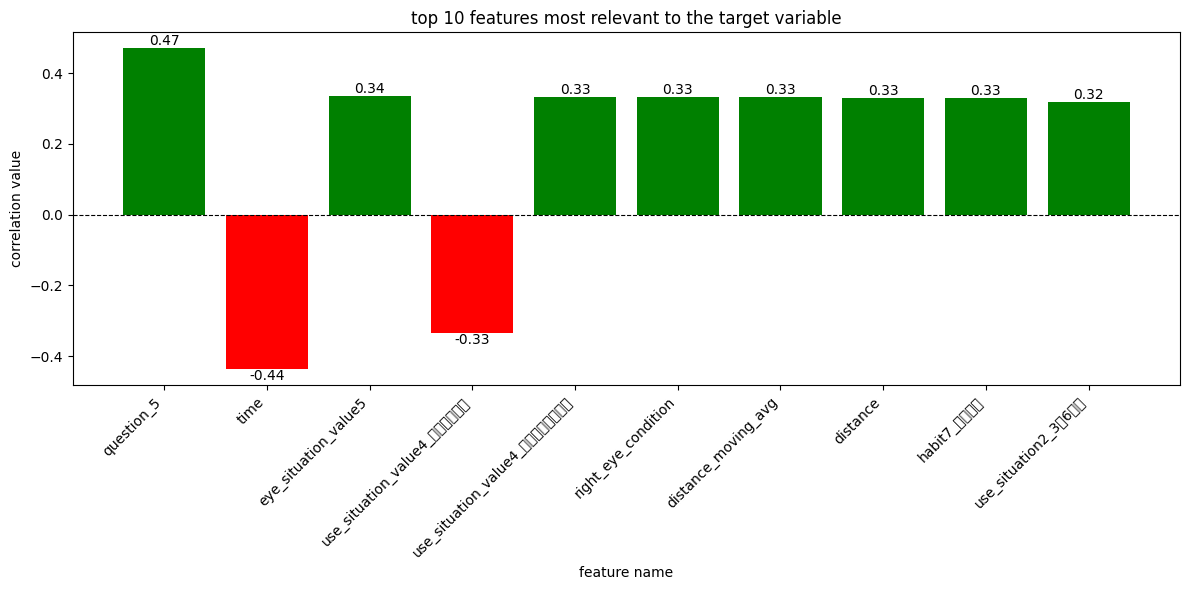

In [ ]:
from matplotlib import pyplot as plt

# 修改：保留相關性的正負值
top_10_features_corr_signed = correlation_matrix[target_variable][selected_features].sort_values(key=lambda x: x.abs(), ascending=False).head(10)

# 繪製長條圖（包含正負值）
plt.figure(figsize=(12, 6))
bars = plt.bar(top_10_features_corr_signed.index, top_10_features_corr_signed.values, color=['green' if val > 0 else 'red' for val in top_10_features_corr_signed.values])

# 添加數值標籤
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.2f}", ha='center', va='bottom' if height > 0 else 'top')

plt.title("top 10 features most relevant to the target variable")
plt.xlabel("feature name")
plt.ylabel("correlation value")
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# 匯入必要函式庫
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, mean_absolute_percentage_error
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

# === 步驟 1: 載入模型與測試資料 ===
xgb_model_file = '/content/xgb_model.pkl'
selected_features_file = '/content/selected_features.pkl'
rnn_model_file = '/content/rnn_model.h5'
scaler_file = '/content/scaler.pkl'
joy_file_path = '/content/Joy_final_data.csv'

# 載入模型
xgb_model = joblib.load(xgb_model_file)
rnn_model = load_model(rnn_model_file)
scaler = joblib.load(scaler_file)
print(f"\n模型已成功載入: XGBoost: {xgb_model_file}, RNN: {rnn_model_file}, Scaler: {scaler_file}")

# 讀取測試資料
joy_data = pd.read_csv(joy_file_path)

# === 資料預處理 ===
def process_joy_data(df):
    df['Transition'] = df.groupby('USER_ID_HASH')['Exhausted_state'].transform(
        lambda x: (x.shift() == 0) & (x == 1)
    ).astype(int)

    def calculate_time_diff(df):
        start_time = df['time'].iloc[0]
        if df['Transition'].sum() > 0:
            transition_time = df.loc[df['Transition'] == 1, 'time'].iloc[0]
            df['time_diff_to_first_exhausted'] = transition_time - start_time
        else:
            df['time_diff_to_first_exhausted'] = 0
        return df

    df = df.groupby('USER_ID_HASH', group_keys=False, as_index=False).apply(calculate_time_diff)

    def add_moving_features(df):
        df['distance_moving_avg'] = df.groupby('USER_ID_HASH')['distance'].transform(
            lambda x: x.rolling(window=5, min_periods=1).mean()
        )
        df['cumulative_distance'] = df.groupby('USER_ID_HASH')['distance'].cumsum()
        df['cumulative_time'] = df.groupby('USER_ID_HASH')['time'].transform(lambda x: x - x.min())
        return df

    df = add_moving_features(df)

    def filter_first_transition(df):
        if df['Transition'].sum() == 0:
            return df
        first_transition_index = df[df['Transition'] == 1].index[0]
        return df[df.index <= first_transition_index]

    filtered_data = df.groupby('USER_ID_HASH', group_keys=False).apply(filter_first_transition).reset_index(drop=True)

    # 填補缺失值
    imputer = KNNImputer(n_neighbors=5)
    filtered_data.fillna(0, inplace=True)  # 避免 NaN 引發錯誤

    return filtered_data

joy_data = process_joy_data(joy_data)

# 載入特徵
selected_features = joblib.load(selected_features_file)
X_joy = joy_data[selected_features]

# === 套用標準化器 ===
X_joy_scaled = scaler.transform(X_joy)

# === XGBoost 預測 ===
xgb_predictions = xgb_model.predict(X_joy_scaled)

# === RNN 預測 ===
# 確保 RNN 的輸入形狀正確
X_rnn = X_joy_scaled  # 確保使用標準化後的輸入
X_rnn = np.expand_dims(X_rnn, axis=1)  # 加入時間序列維度 (假設 RNN 預期 shape 為 [samples, time_steps, features])
rnn_predictions = rnn_model.predict(X_rnn).flatten()

# === 加權平均合併預測 ===
combined_predictions = 0.07 * xgb_predictions + 0.93 * rnn_predictions

# 如果存在實際標籤，計算評估分數
if 'time_diff_to_first_exhausted' in joy_data.columns:
    joy_mae = mean_absolute_error(joy_data['time_diff_to_first_exhausted'], combined_predictions)
    joy_r2 = r2_score(joy_data['time_diff_to_first_exhausted'], combined_predictions)
    joy_mse = mean_squared_error(joy_data['time_diff_to_first_exhausted'], combined_predictions)
    joy_mape = mean_absolute_percentage_error(joy_data['time_diff_to_first_exhausted'], combined_predictions)
    accuracy = np.mean(np.abs(combined_predictions - joy_data['time_diff_to_first_exhausted']) <= 0.5)

    print(f"\n測試集評估結果:")
    print(f"MAE: {joy_mae:.4f}")
    print(f"MSE: {joy_mse:.4f}")
    print(f"R² 分數: {joy_r2:.4f}")
    print(f"MAPE: {joy_mape:.4f}")
    print(f"準確率 (Accuracy): {accuracy:.4f}")
else:
    print("\n測試集缺少標籤，無法計算評估分數。")

<ipython-input-4-81abb5412590>:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('USER_ID_HASH', group_keys=False, as_index=False).apply(calculate_time_diff)
<ipython-input-4-81abb5412590>:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_data = df.groupby('USER_ID_HASH', group_keys=False).apply(filter_first_transition).reset_index(drop=True)



模型已成功載入: XGBoost: /content/xgb_model.pkl, RNN: /content/rnn_model.h5, Scaler: /content/scaler.pkl
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step

測試集評估結果:
MAE: 8.5981
MSE: 277.7200
R² 分數: -0.1026
MAPE: 795777430648453.0000
準確率 (Accuracy): 0.7160


In [ ]:
# === 匯入必要函式庫 ===
import pandas as pd
import numpy as np
import joblib
from sklearn.impute import KNNImputer
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

# === 步驟 1: 載入模型與測試資料 ===
rnn_model_file = '/content/rnn_model.h5'
scaler_file = '/content/scaler.pkl'
selected_features_file = '/content/selected_features.pkl'
joy_file_path = '/content/Joy_final_data.csv'

# 載入 RNN 模型
rnn_model = load_model(rnn_model_file)
print(f"\nRNN 模型已成功載入: {rnn_model_file}")

# 載入標準化器
scaler = joblib.load(scaler_file)
print(f"\n標準化器已成功載入: {scaler_file}")

# 讀取測試資料
joy_data = pd.read_csv(joy_file_path)

# === 資料預處理 ===
def process_joy_data(df):
    df['Transition'] = df.groupby('USER_ID_HASH')['Exhausted_state'].transform(
        lambda x: (x.shift() == 0) & (x == 1)
    ).astype(int)

    def calculate_time_diff(df):
        start_time = df['time'].iloc[0]
        if df['Transition'].sum() > 0:  # 如果有轉變
            transition_time = df.loc[df['Transition'] == 1, 'time'].iloc[0]
            df['time_diff_to_first_exhausted'] = transition_time - start_time
        else:
            df['time_diff_to_first_exhausted'] = 0
        return df

    df = df.groupby('USER_ID_HASH', group_keys=False, as_index=False).apply(calculate_time_diff)

    def add_moving_features(df):
        df['distance_moving_avg'] = df.groupby('USER_ID_HASH')['distance'].transform(
            lambda x: x.rolling(window=5, min_periods=1).mean()
        )
        return df

    df = add_moving_features(df)

    def filter_first_transition(df):
        if df['Transition'].sum() == 0:
            return df
        first_transition_index = df[df['Transition'] == 1].index[0]
        return df[df.index <= first_transition_index]

    filtered_data = df.groupby('USER_ID_HASH', group_keys=False).apply(filter_first_transition).reset_index(drop=True)

    # 填補缺失值
    imputer = KNNImputer(n_neighbors=5)
    filtered_data.fillna(0, inplace=True)  # 避免 NaN 引發錯誤

    return filtered_data

joy_data = process_joy_data(joy_data)

# 載入特徵
selected_features = joblib.load(selected_features_file)
X_joy = joy_data[selected_features]

# === 標準化資料並準備 RNN 輸入 ===
X_joy_scaled = scaler.transform(X_joy)
X_joy_rnn = X_joy_scaled.reshape((X_joy_scaled.shape[0], 1, X_joy_scaled.shape[1]))

# === 預測 ===
joy_y_pred = rnn_model.predict(X_joy_rnn).flatten()

# 還原對數變換
joy_data['Predicted_time_diff'] = np.expm1(joy_y_pred)

# 如果存在實際標籤，計算評估分數
if 'time_diff_to_first_exhausted' in joy_data.columns:
    joy_y_actual = joy_data['time_diff_to_first_exhausted']
    joy_mae = mean_absolute_error(joy_y_actual, joy_data['Predicted_time_diff'])
    joy_r2 = r2_score(joy_y_actual, joy_data['Predicted_time_diff'])
    joy_mse = mean_squared_error(joy_y_actual, joy_data['Predicted_time_diff'])
    joy_mape = mean_absolute_percentage_error(joy_y_actual, joy_data['Predicted_time_diff'])

    print(f"\n測試集評估結果:")
    print(f"MAE: {joy_mae:.4f}")
    print(f"MSE: {joy_mse:.4f}")
    print(f"R² 分數: {joy_r2:.4f}")
    print(f"MAPE: {joy_mape:.4f}")
else:
    print("\n測試集缺少標籤，無法計算評估分數。")

# 儲存預測結果
output_file = '/content/Joy_final_predictions_rnn.csv'
joy_data.to_csv(output_file, index=False)
print(f"\n預測結果已儲存至: {output_file}")

<ipython-input-16-a020de519786>:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('USER_ID_HASH', group_keys=False, as_index=False).apply(calculate_time_diff)
<ipython-input-16-a020de519786>:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_data = df.groupby('USER_ID_HASH', group_keys=False).apply(filter_first_transition).reset_index(drop=True)



RNN 模型已成功載入: /content/rnn_model.h5

標準化器已成功載入: /content/scaler.pkl
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step

測試集評估結果:
MAE: 2.4742
MSE: 33.3932
R² 分數: 0.8674
MAPE: 31328510573605.9922

預測結果已儲存至: /content/Joy_final_predictions_rnn.csv
